## Read in the appropriate packages

In [ ]:
!pip install pmdarima -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.5 MB/s eta 0:00:00


In [ ]:
from pandas_datareader import data as pdr #read data from yahoo finance api
import matplotlib.pyplot as plt #viz #GUI manager
import seaborn as sns #viz #plotly is another package
import datetime
import pandas as pd
import numpy as np
from pandas import Grouper #groupby
#statistical data exploration, conducting statistical tests, and estimation of different statistical models
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #autocorrelation plot
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from pandas.plotting import autocorrelation_plot #autocorrelation plot
from statsmodels.graphics.gofplots import qqplot #residual diagnostics
from sklearn.metrics import mean_squared_error #accuracy metrics
from math import sqrt
from sklearn.metrics import mean_absolute_error #accuracy metrics

from random import gauss #create gaussian white noise
from random import seed
from pandas import Series

from statsmodels.tsa.stattools import adfuller # Augmented Dickey Fuller test for testing stationarity

from statsmodels.tsa.arima_model import ARIMA #for manual ARIMA

import pmdarima as pm #auto arima


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Forecast Num_Orders**

## **Load Data**

In [ ]:
df_order = pd.read_csv("/content/drive/MyDrive/ts_project/train.csv")
print("Number of centers:", df_order['center_id'].unique().shape[0])
df_order

Number of centers: 77


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40
...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68
456544,1062036,145,61,2304,482.09,482.09,0,0,42
456545,1110849,145,61,2664,237.68,321.07,0,0,501
456546,1147725,145,61,2569,243.50,313.34,0,0,729


In [ ]:
df_order ['center_id'].unique()

array([ 55,  24,  11,  83,  32,  13, 109,  52,  93, 186, 146,  57, 149,
        89, 124, 152,  97,  74, 108,  99,  66,  94,  91,  20,  34, 137,
        92, 126,  36, 162,  75, 177,  27, 157, 106,  64, 129,  14,  17,
       153, 139, 161,  81,  26,  73,  50, 104,  42, 113, 145,  53,  72,
        67, 174,  29,  77,  41,  30,  76,  59,  88, 143,  58,  10, 101,
        80,  43,  65,  39, 102, 110, 132,  23,  86,  68,  51,  61])

## **Viz one center**

In [ ]:
df_55=df_order [df_order ['center_id']==55]
df_55

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40
...,...,...,...,...,...,...,...,...,...
453310,1080904,145,55,1543,484.03,485.03,0,0,26
453311,1457109,145,55,2304,486.03,485.03,0,0,14
453312,1217639,145,55,2664,257.05,307.52,0,0,230
453313,1409180,145,55,2569,242.53,308.52,0,0,148


In [ ]:
ts_orders = df_55.groupby(['week', 'meal_id']).sum().reset_index()[['week','meal_id','num_orders']]
ts_orders

,week,meal_id,num_orders
0,1,1062,391
1,1,1109,756
2,1,1207,676
3,1,1230,823
4,1,1248,28
...,...,...,...
5141,145,2664,230
5142,145,2704,42
5143,145,2707,162
5144,145,2826,162


In [ ]:
df_order.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders'],
      dtype='object')

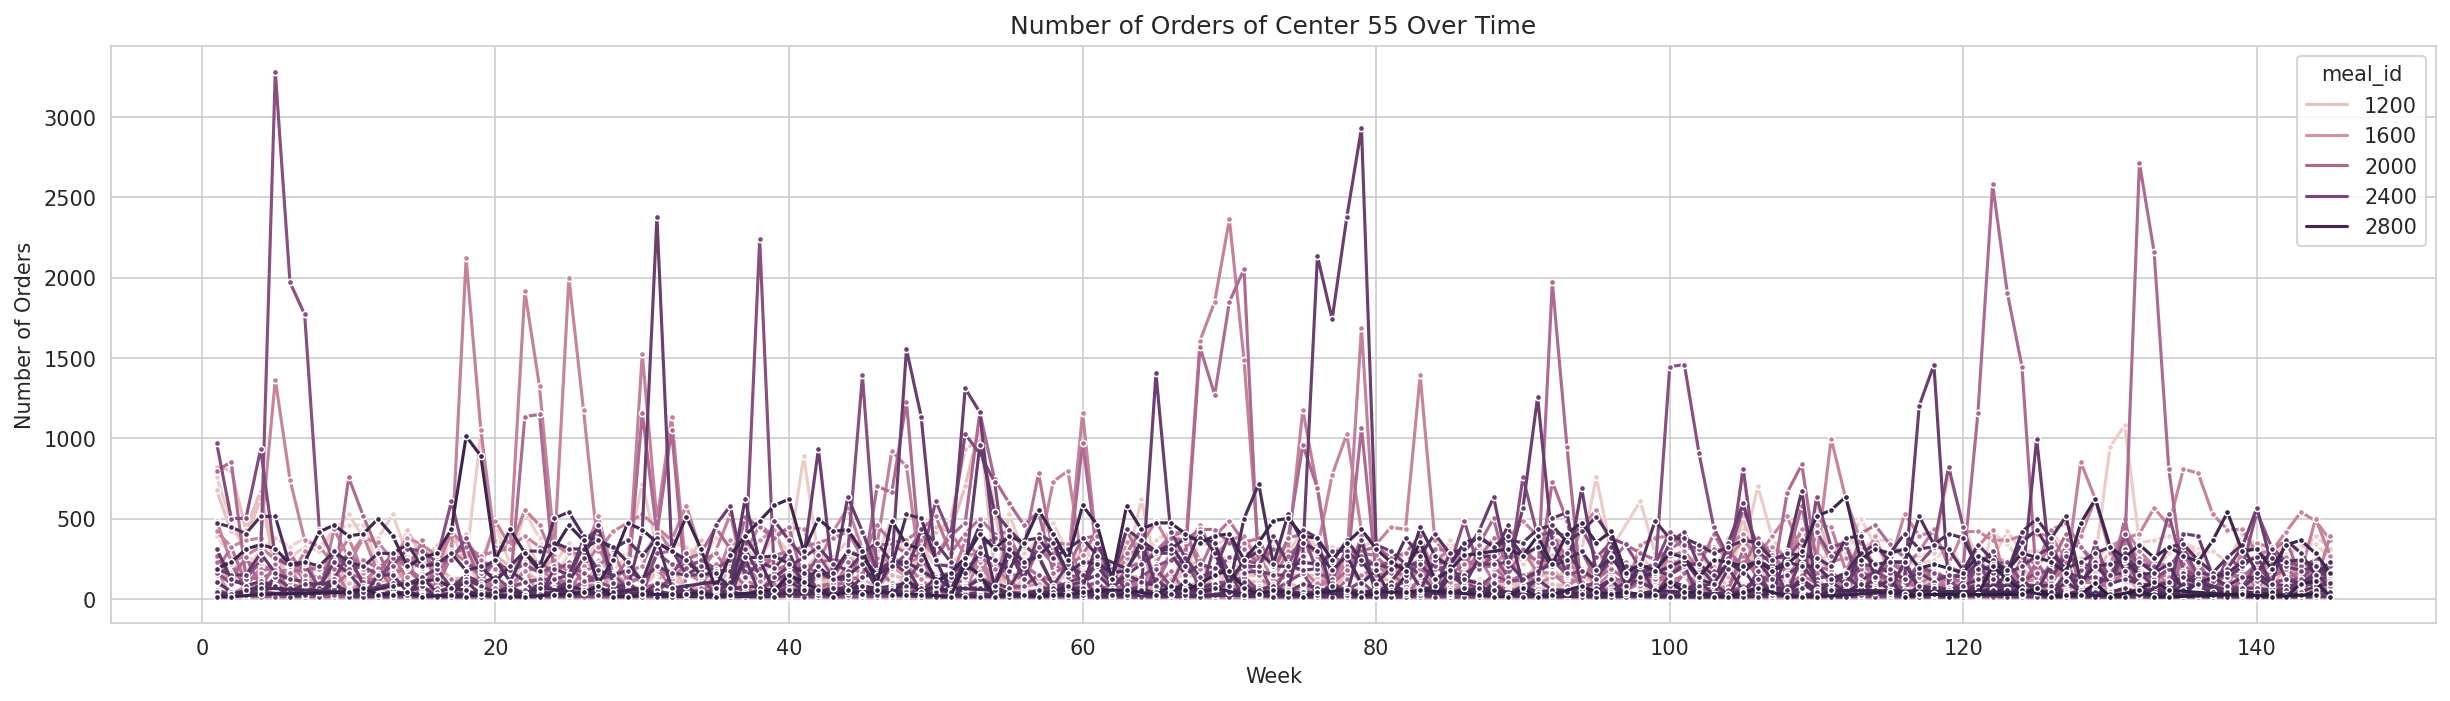

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

plt.figure(figsize=(20, 5), dpi=150)
sns.lineplot(data=ts_orders, x='week', y='num_orders', hue='meal_id', marker='.')

plt.title('Number of Orders of Center 55 Over Time')
plt.xlabel('Week')
plt.ylabel('Number of Orders')

# Show the plot
plt.show()

## **Aggregate all centers**

In [ ]:
#sum orders
num_orders_agg = df_order[['num_orders', 'week', 'meal_id']].groupby(['week', 'meal_id']).sum().reset_index()
num_orders_agg

#avg other features
others = df_order[['week', 'meal_id', 'checkout_price', 'base_price',
                   'emailer_for_promotion', 'homepage_featured']].groupby(['week', 'meal_id']).mean().reset_index().drop(columns=['week', 'meal_id'])
others

df_agg = pd.concat([num_orders_agg, others], axis=1)
df_agg

,week,meal_id,num_orders,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1,1062,28943,176.202727,176.202727,0.000000,0.000000
1,1,1109,63984,265.711948,289.463636,0.467532,0.012987
2,1,1198,5391,176.016154,203.690385,0.000000,0.038462
3,1,1207,20893,320.114658,350.067945,0.054795,0.205479
4,1,1216,3956,417.256364,436.736212,0.000000,0.181818
...,...,...,...,...,...,...,...
7168,145,2707,39833,218.343766,222.084805,0.000000,0.000000
7169,145,2760,16390,175.040704,252.814507,0.000000,0.352113
7170,145,2826,25706,350.731039,350.588182,0.000000,0.000000
7171,145,2867,1630,719.729808,726.951154,0.000000,0.115385


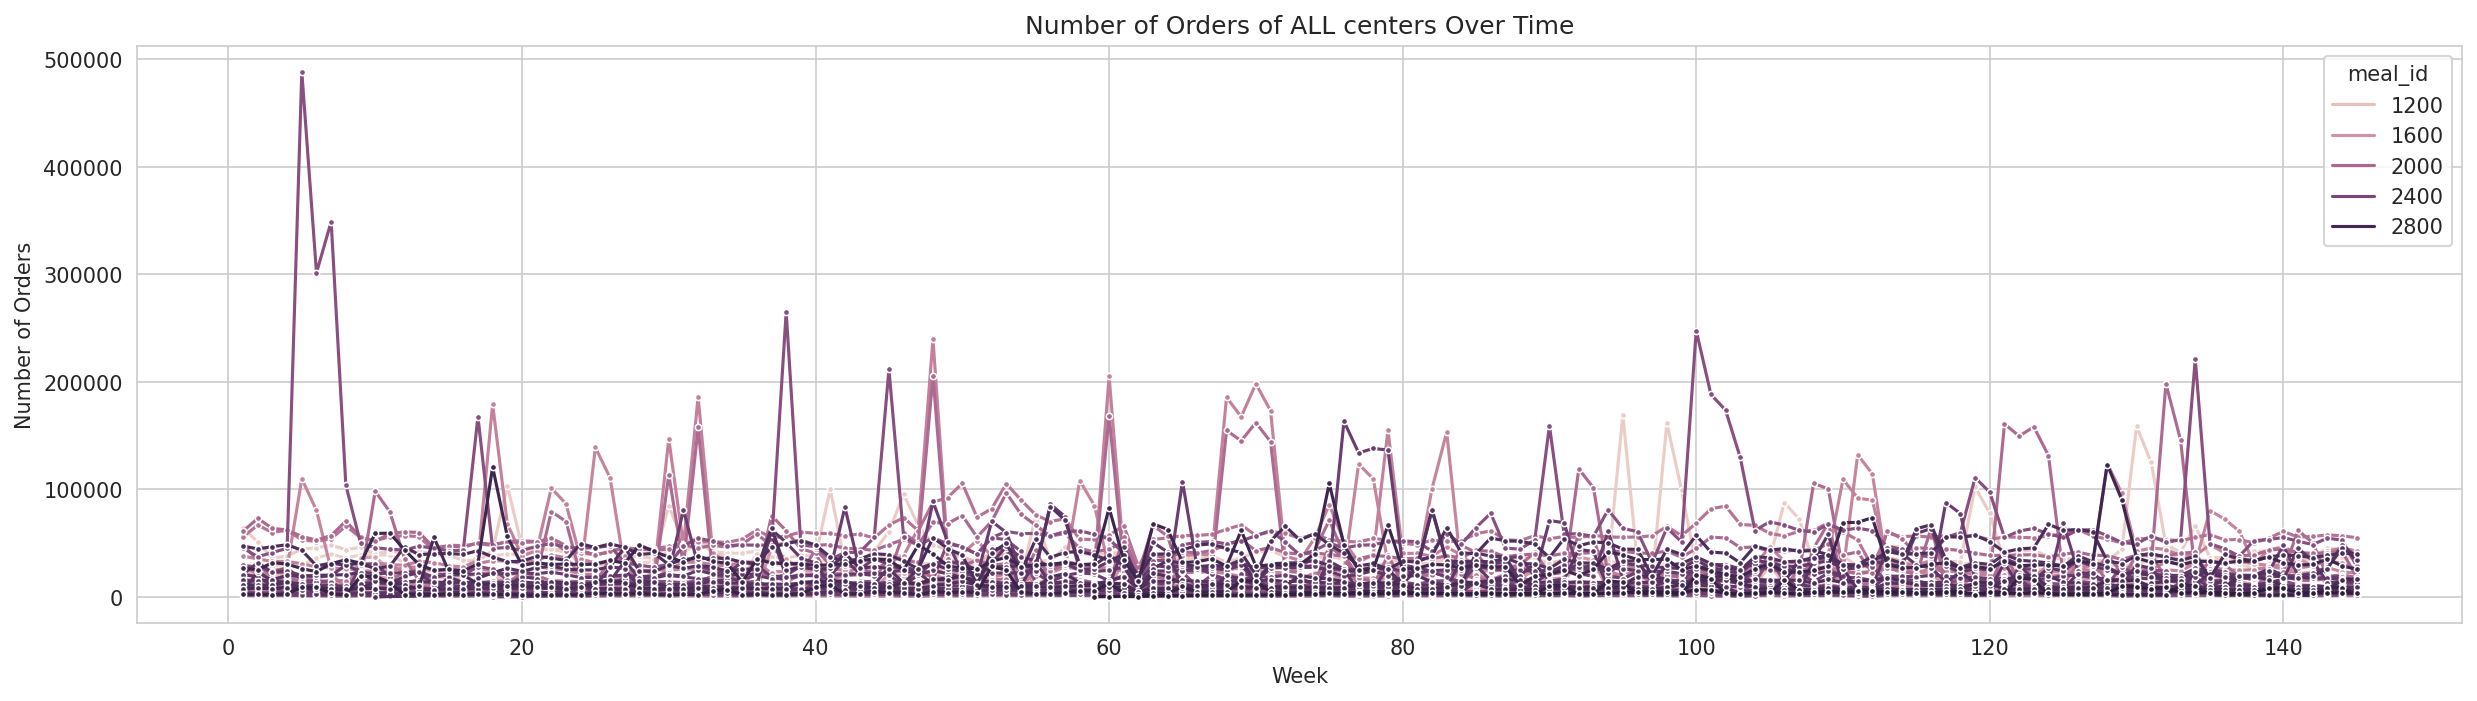

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

plt.figure(figsize=(20, 5), dpi=150)
sns.lineplot(data=df_agg, x='week', y='num_orders', hue='meal_id', marker='.')

plt.title('Number of Orders of ALL centers Over Time')
plt.xlabel('Week')
plt.ylabel('Number of Orders')

# Show the plot
plt.show()

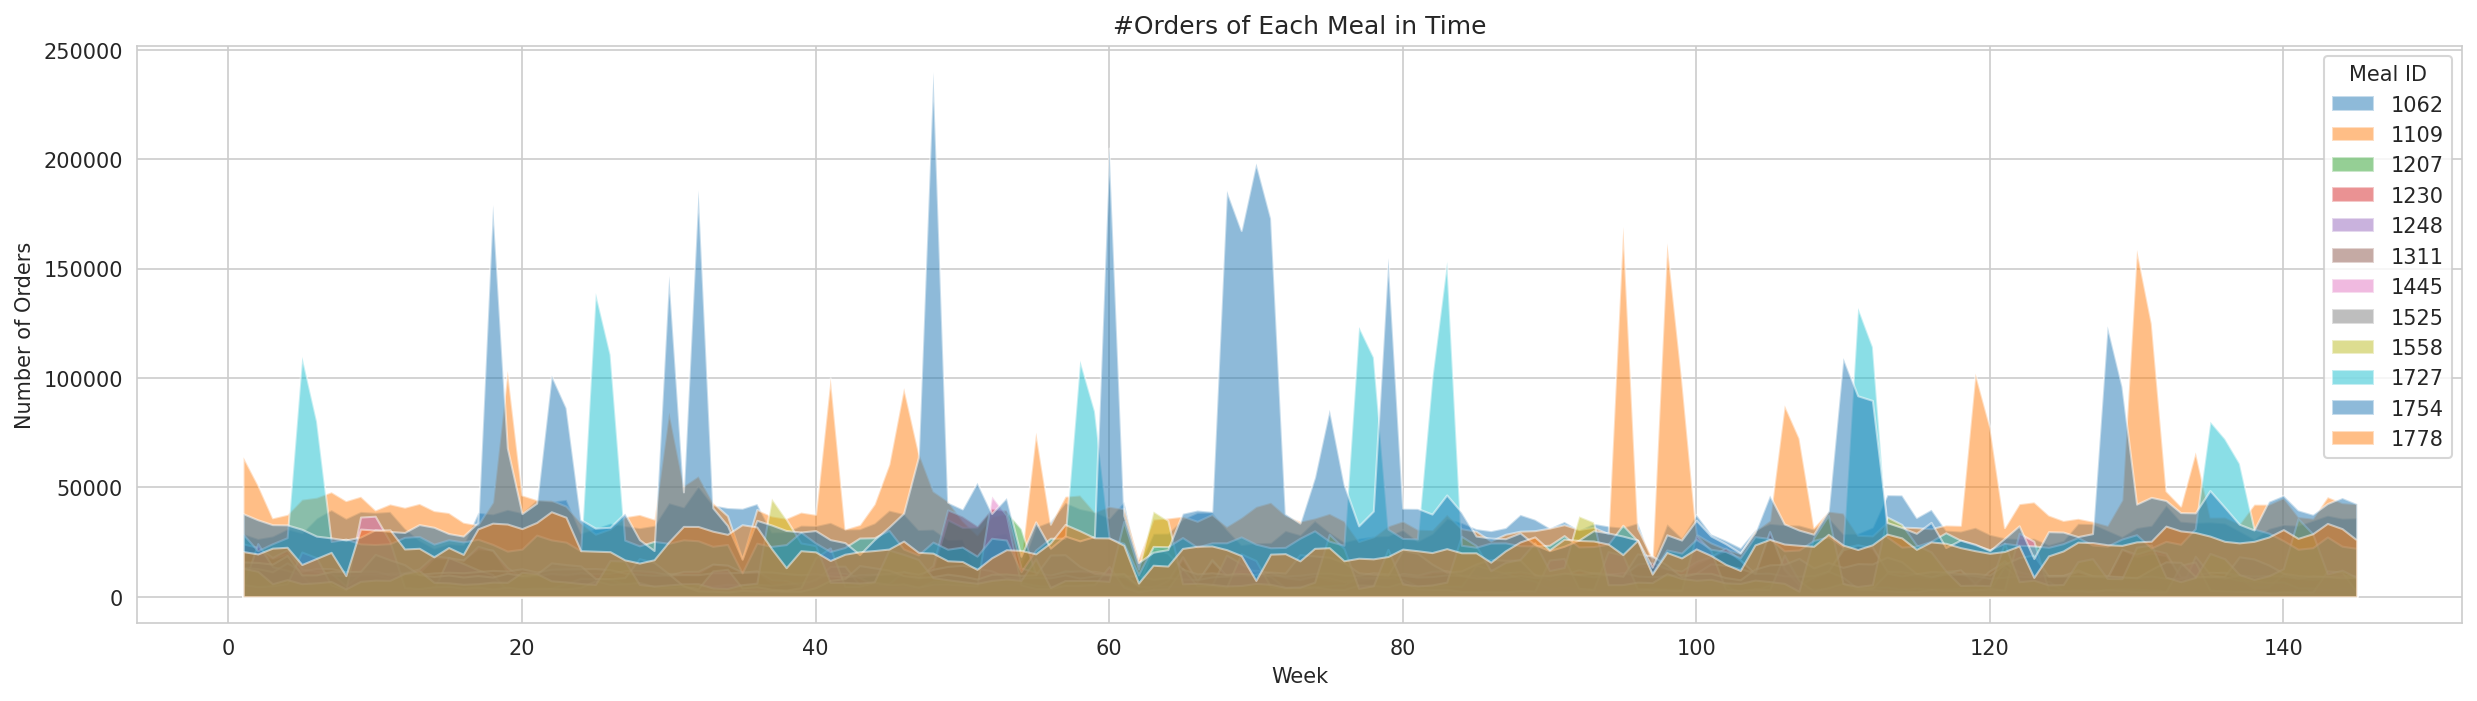

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(20, 5), dpi=150)
meals = ts_orders['meal_id'].unique()

for i in range(len(meals)):
    meal_id = meals[i]

    dff = df_agg[df_agg['meal_id'] == meal_id]
    dff = dff.sort_values(by='week')

    # Plot the area
    plt.fill_between(dff['week'], dff['num_orders'], label=meal_id, alpha=0.5)
    if i>10:
      break

# Adding title and labels
plt.title('#Orders of Each Meal in Time')
plt.xlabel('Week')
plt.ylabel('Number of Orders')

plt.legend(title='Meal ID')
plt.show()

In [ ]:
# df_meal = pd.read_csv("/content/drive/MyDrive/ts_project/meal_info.csv")
# df_meal

In [ ]:
# len(df_meal[['category', 'cuisine']].drop_duplicates()) #17 number of food type

In [ ]:
# df_center = pd.read_csv("/content/drive/MyDrive/ts_project/fulfilment_center_info.csv")
# print("Number of centers:", df_center['center_id'].unique().shape[0])
# df_center

In [ ]:
# df_agg = df_agg.merge(df_meal, on='meal_id', how='inner')
# df_agg = df_agg.merge(df_center, on='center_id', how='inner')
print(df_agg.isnull().sum())
df_agg

week                     0
meal_id                  0
num_orders               0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
dtype: int64


,week,meal_id,num_orders,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1,1062,28943,176.202727,176.202727,0.000000,0.000000
1,1,1109,63984,265.711948,289.463636,0.467532,0.012987
2,1,1198,5391,176.016154,203.690385,0.000000,0.038462
3,1,1207,20893,320.114658,350.067945,0.054795,0.205479
4,1,1216,3956,417.256364,436.736212,0.000000,0.181818
...,...,...,...,...,...,...,...
7168,145,2707,39833,218.343766,222.084805,0.000000,0.000000
7169,145,2760,16390,175.040704,252.814507,0.000000,0.352113
7170,145,2826,25706,350.731039,350.588182,0.000000,0.000000
7171,145,2867,1630,719.729808,726.951154,0.000000,0.115385


In [ ]:
# df_agg.to_csv("time_series.csv")

In [ ]:
df = df_agg   #.drop(columns = ['meal_id']) #meal id equivalent to category and cuisine


## **Create Time series by first sorting by meal, then week**

In [ ]:
df = df.sort_values(['meal_id', 'week'])
df = df[df['meal_id']==1062]
df

,week,meal_id,num_orders,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1,1062,28943,176.202727,176.202727,0.000000,0.000000
45,2,1062,26695,180.710649,180.840519,0.000000,0.000000
90,3,1062,27844,180.499221,180.538182,0.000000,0.000000
135,4,1062,31144,180.664156,180.703117,0.000000,0.000000
180,5,1062,29324,175.263816,176.375395,0.000000,0.000000
...,...,...,...,...,...,...,...
6918,141,1062,32729,179.085195,179.847273,0.000000,0.000000
6969,142,1062,34990,172.171948,174.543766,0.000000,0.000000
7020,143,1062,37333,172.362078,174.762208,0.000000,0.000000
7071,144,1062,35981,172.048701,173.812727,0.000000,0.000000


In [ ]:
df['week']

0         1
45        2
90        3
135       4
180       5
       ... 
6918    141
6969    142
7020    143
7071    144
7122    145
Name: week, Length: 145, dtype: int64

## **Encoding**

In [ ]:
max_week_quarter = 12  # maximum number of weeks in a quarter
max_week_month = 4  # maximum number of weeks in a month
df = pd.concat([pd.Series(np.sin(2 * np.pi * df['week'] / max_week_quarter), name ='week_sin_quarter'), df], axis =1)
df = pd.concat([pd.Series(np.cos(2 * np.pi * df['week'] / max_week_quarter), name ='week_cos_quarter'), df], axis =1)
df = pd.concat([pd.Series(np.sin(2 * np.pi * df['week'] / max_week_month), name ='week_sin_month'), df], axis =1)
df = pd.concat([pd.Series(np.cos(2 * np.pi * df['week'] / max_week_month), name ='week_cos_month'), df], axis =1)
df

,week_cos_month,week_sin_month,week_cos_quarter,week_sin_quarter,week,meal_id,num_orders,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,6.123234e-17,1.000000e+00,8.660254e-01,5.000000e-01,1,1062,28943,176.202727,176.202727,0.000000,0.000000
45,-1.000000e+00,1.224647e-16,5.000000e-01,8.660254e-01,2,1062,26695,180.710649,180.840519,0.000000,0.000000
90,-1.836970e-16,-1.000000e+00,6.123234e-17,1.000000e+00,3,1062,27844,180.499221,180.538182,0.000000,0.000000
135,1.000000e+00,-2.449294e-16,-5.000000e-01,8.660254e-01,4,1062,31144,180.664156,180.703117,0.000000,0.000000
180,3.061617e-16,1.000000e+00,-8.660254e-01,5.000000e-01,5,1062,29324,175.263816,176.375395,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
6918,2.106826e-14,1.000000e+00,-1.175970e-14,-1.000000e+00,141,1062,32729,179.085195,179.847273,0.000000,0.000000
6969,-1.000000e+00,-1.963149e-15,5.000000e-01,-8.660254e-01,142,1062,34990,172.171948,174.543766,0.000000,0.000000
7020,-3.427154e-15,-1.000000e+00,8.660254e-01,-5.000000e-01,143,1062,37333,172.362078,174.762208,0.000000,0.000000
7071,1.000000e+00,-8.817457e-15,1.000000e+00,-2.939152e-15,144,1062,35981,172.048701,173.812727,0.000000,0.000000


<Axes: xlabel='week', ylabel='num_orders'>

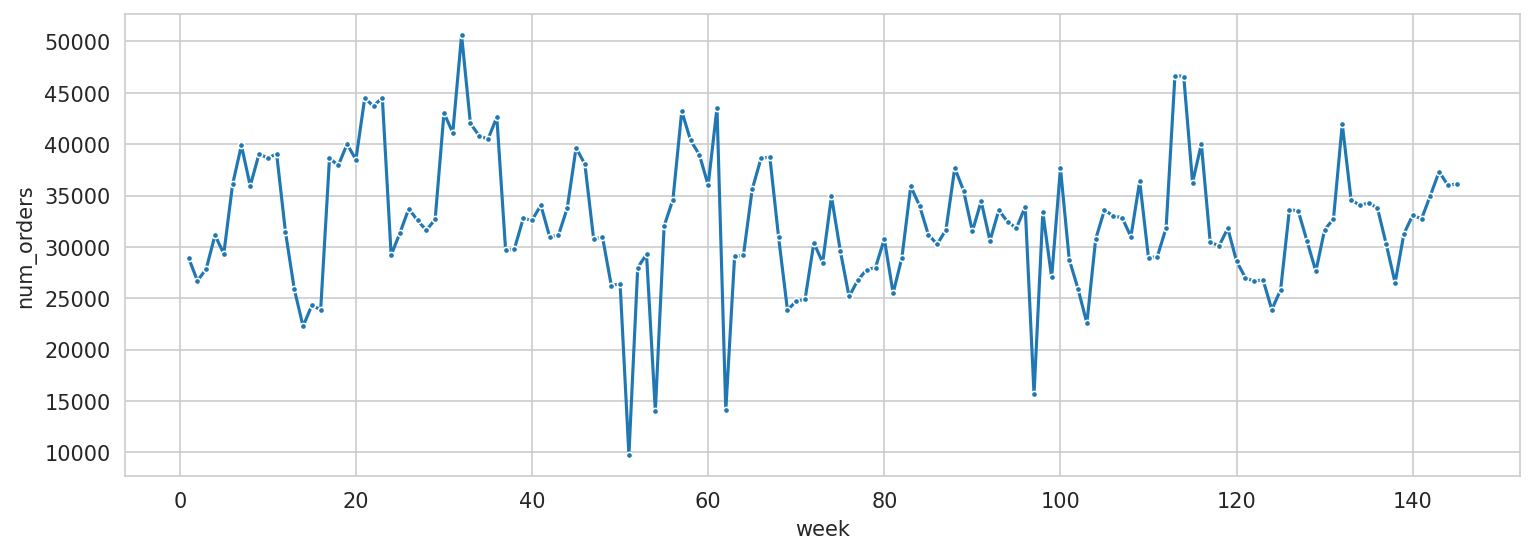

In [ ]:
plt.figure(figsize=(12,4),dpi=150)
sns.lineplot(data=df, x='week', y='num_orders', marker='.')

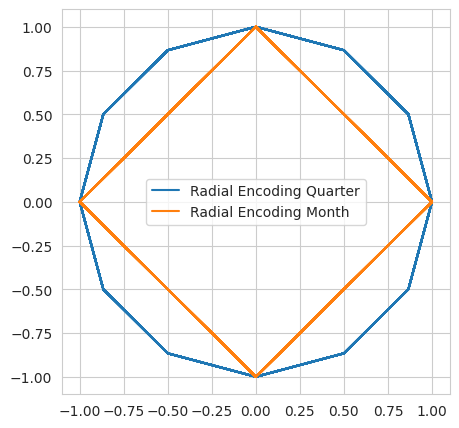

In [ ]:
plt.figure(figsize=(5,5), dpi=100)
plt.plot(df[:1000]['week_cos_quarter'], df[:1000]['week_sin_quarter'], label = 'Radial Encoding Quarter')
plt.plot(df[:1000]['week_cos_month'], df[:1000]['week_sin_month'], label = 'Radial Encoding Month')
plt.legend()

## **ML Models**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error #accuracy metrics
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor #direct multioutput wrapper
from sklearn.model_selection import TimeSeriesSplit
def mape(pred, actual):
  return np.mean(np.abs((actual - pred) / actual)) * 100


In [ ]:

from tqdm.auto import tqdm
def split_sequences(sequences, context_len, pred_len, jump, pred_column):
    X, y = [], []
    for i in tqdm(range(0, len(sequences), jump)):
        # find pred window (start, end).
        start = i + context_len
        end = start + pred_len
        # check if we are beyond the dataset
        if end > len(sequences):
            break
        # seq_x: i~start, seq_y: start~end
        seq_x, seq_y = sequences.iloc[i:start], sequences.iloc[start:end][pred_column]
        # seq_x = seq_x[seq_x.columns.difference([pred_column])]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


context_len, pred_len = 20, 20
jump = 1
X, y = split_sequences(df, context_len, pred_len, jump, 'num_orders')
print("X", X.shape, "y", y.shape)

  0%|          | 0/145 [00:00<?, ?it/s]

X (106, 20, 11) y (106, 20)


In [ ]:
X = X.reshape(X.shape[0], -1) #Flatten time and dim for ML models.
X.shape

(106, 220)

In [ ]:
portion = X.shape[0]- pred_len
print("Train samples", portion)
X_train, X_test=X[:portion], X[portion:]
y_train, y_test=y[:portion], y[portion:]

Train samples 86


In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
y_scale = 1e-5
y_train, y_test = y_train*y_scale, y_test*y_scale
#perform pca on the standardized data
from sklearn.decomposition import PCA

# pca = PCA(n_components = 0.99) #capture 99% of the variation in the dataset
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)
X_train.shape

(86, 220)

In [ ]:
model = MultiOutputRegressor(GradientBoostingRegressor())
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print("train mse", mean_squared_error(y_train_pred.reshape(-1), y_train.reshape(-1)))
print("train rmse", mean_squared_error(y_train_pred.reshape(-1), y_train.reshape(-1))**0.5)
print("train mae", mean_absolute_error(y_train_pred.reshape(-1), y_train.reshape(-1)))
print("train mape", mape(y_train_pred.reshape(-1), y_train.reshape(-1)))
# print("test corr", np.corrcoef(y_train_pred.reshape(-1), y_train.reshape(-1))[0,1])
print()

y_test_pred = model.predict(X_test)
print("test mse", mean_squared_error(y_test_pred.reshape(-1), y_test.reshape(-1)))
print("test rmse", mean_squared_error(y_test_pred.reshape(-1), y_test.reshape(-1))**0.5)
print("test mae", mean_absolute_error(y_test_pred.reshape(-1), y_test.reshape(-1)))
print("test mape", mape(y_test_pred.reshape(-1), y_test.reshape(-1)))
# print("test corr", np.corrcoef(y_test_pred.reshape(-1), y_test.reshape(-1))[0,1])

train mse 1.1088228045176461e-05
train rmse 0.003329899104353833
train mae 0.002728281205061005
train mape 0.9550933436621332

test mse 0.007811783752998203
test rmse 0.0883842958505537
test mae 0.07351419789495506
test mape 23.917792368884626


In [ ]:
model = MultiOutputRegressor(XGBRegressor(eta=0.2, gamma=0.001, max_depth=4))
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print("train mse", mean_squared_error(y_train_pred.reshape(-1), y_train.reshape(-1)))
print("train rmse", mean_squared_error(y_train_pred.reshape(-1), y_train.reshape(-1))**0.5)
print("train mae", mean_absolute_error(y_train_pred.reshape(-1), y_train.reshape(-1)))
print("train mape", mape(y_train_pred.reshape(-1), y_train.reshape(-1)))
# print("test corr", np.corrcoef(y_train_pred.reshape(-1), y_train.reshape(-1))[0,1])
print()

y_test_pred = model.predict(X_test)
print("test mse", mean_squared_error(y_test_pred.reshape(-1), y_test.reshape(-1)))
print("test rmse", mean_squared_error(y_test_pred.reshape(-1), y_test.reshape(-1))**0.5)
print("test mae", mean_absolute_error(y_test_pred.reshape(-1), y_test.reshape(-1)))
print("test mape", mape(y_test_pred.reshape(-1), y_test.reshape(-1)))
# print("test corr", np.corrcoef(y_test_pred.reshape(-1), y_test.reshape(-1))[0,1])

train mse 0.0001750545176793403
train rmse 0.013230816969459607
train mae 0.009693287433311
train mape 3.675873849672071

test mse 0.007013120331336826
test rmse 0.08374437492355427
test mae 0.06816888180553912
test mape 22.229642039469365


In [ ]:
model = MultiOutputRegressor(RandomForestRegressor())
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print("train mse", mean_squared_error(y_train_pred.reshape(-1), y_train.reshape(-1)))
print("train rmse", mean_squared_error(y_train_pred.reshape(-1), y_train.reshape(-1))**0.5)
print("train mae", mean_absolute_error(y_train_pred.reshape(-1), y_train.reshape(-1)))
print("train mape", mape(y_train_pred.reshape(-1), y_train.reshape(-1)))
# print("test corr", np.corrcoef(y_train_pred.reshape(-1), y_train.reshape(-1))[0,1])
print()

y_test_pred = model.predict(X_test)
print("test mse", mean_squared_error(y_test_pred.reshape(-1), y_test.reshape(-1)))
print("test rmse", mean_squared_error(y_test_pred.reshape(-1), y_test.reshape(-1))**0.5)
print("test mae", mean_absolute_error(y_test_pred.reshape(-1), y_test.reshape(-1)))
print("test mape", mape(y_test_pred.reshape(-1), y_test.reshape(-1)))
# print("test corr", np.corrcoef(y_test_pred.reshape(-1), y_test.reshape(-1))[0,1])

train mse 0.0005128134259477388
train rmse 0.02264538420843724
train mae 0.01632613529069767
train mape 6.339904664541028

test mse 0.006364812385622728
test rmse 0.07977977428911871
test mae 0.06640054875000001
test mape 21.647226163994063


## **Plot predictions**

In [ ]:
pred_len = 20
jump = pred_len
X, y = split_sequences(df, context_len, pred_len, jump, 'num_orders')
X = X.reshape(X.shape[0], -1) #Flatten time and dim for ML models.
X = sc.transform(X)
print("X", X.shape, "y", y.shape)

  0%|          | 0/8 [00:00<?, ?it/s]

X (6, 220) y (6, 20)


In [ ]:
y_train_pred = model.predict(X[:-1]).reshape(-1)
y_pred  = model.predict(X[-1:]).reshape(-1)
print(y_train_pred.shape, y_pred.shape)


(100,) (20,)


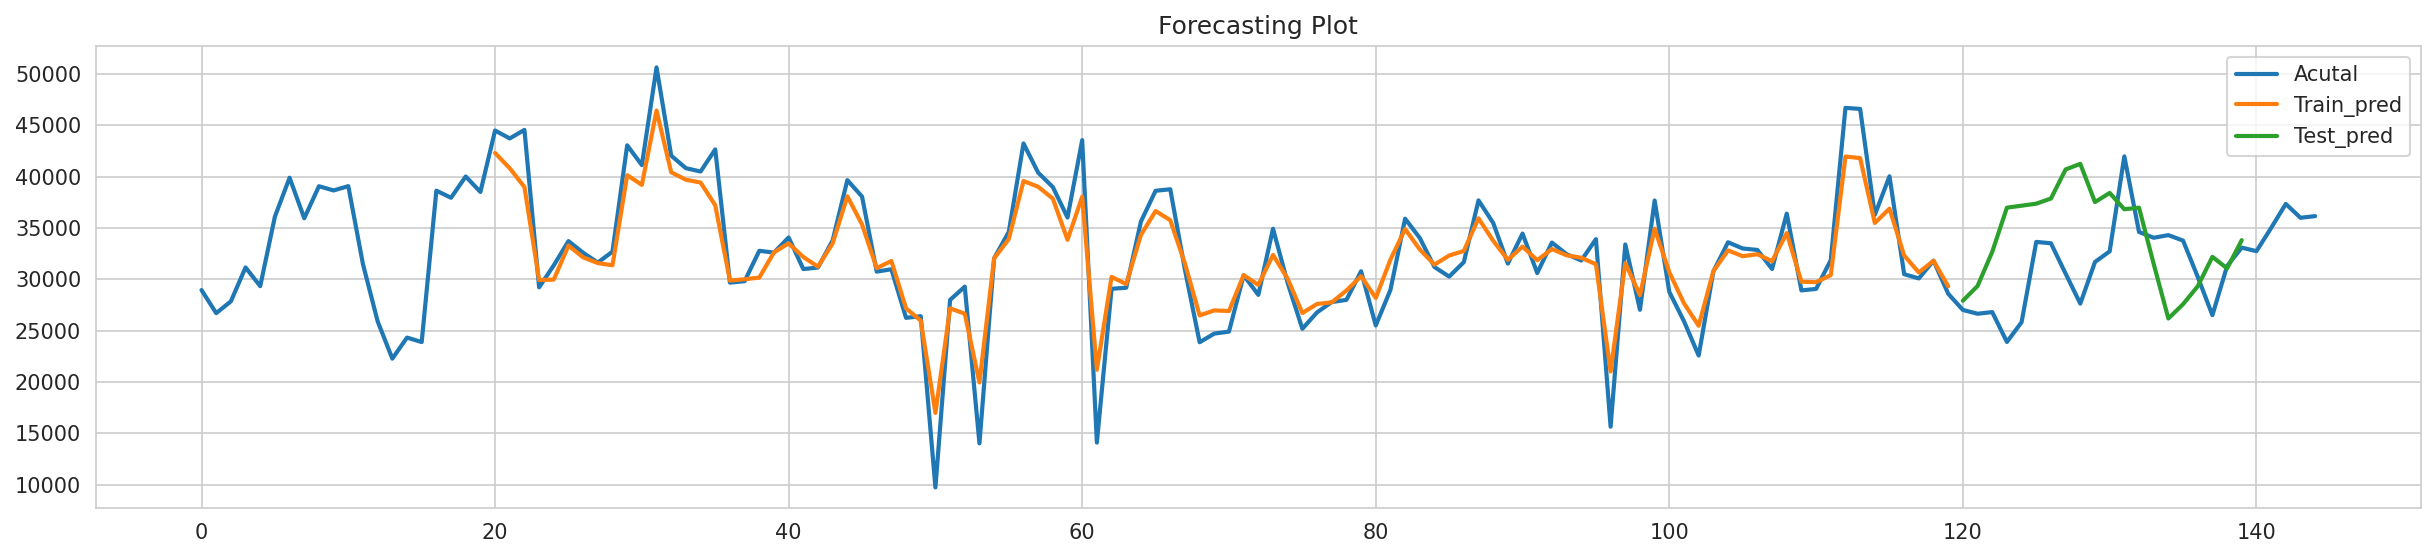

In [ ]:
plt.figure(figsize=(20,4), dpi=150)
plt.plot(np.arange(0, len(df['num_orders'])), df['num_orders'], linewidth=2, label='Acutal')
plt.plot(np.arange(context_len, context_len+y_train_pred.shape[0]),1/y_scale*y_train_pred, linewidth=2, label='Train_pred')
plt.plot(np.arange(context_len+y_train_pred.shape[0], context_len+y_train_pred.shape[0]+y_pred.shape[0]), 1/y_scale*y_pred, linewidth=2, label='Test_pred')
plt.title("Forecasting Plot")
plt.legend()

## **Sequential Training & Backtesting**

In [ ]:
print("Time:", len(df)) #80, 20, 20, 20

Time: 145


In [ ]:
def Backtesting(periods=3):
    backtesting_train=[]
    backtesting_test=[]
    X, y = [], []
    context_len, pred_len= 20, 20
    window_len = context_len + pred_len
    sequences = [(0,80), (0,100), (0,120)]
    test =[(60,100), (80, 120), (100,140)]
    for t in range(periods):
      a,b = sequences[t]
      X_train, y_train = split_sequences(df.iloc[a:b], context_len, pred_len, jump=1, pred_column='num_orders')
      print("X_train", X_train.shape, "y_train", y_train.shape)
      a,b = test[t]
      X_test, y_test = split_sequences(df.iloc[a:b], context_len, pred_len, jump=pred_len, pred_column='num_orders')
      print("X_test", X_test.shape, "y_test", y_test.shape)


      backtesting_train.append((np.array(X_train), np.array(y_train)))
      backtesting_test.append((np.array(X_test), np.array(y_test)))
    return backtesting_train, backtesting_test

backtesting_train, backtesting_test = Backtesting()


  0%|          | 0/80 [00:00<?, ?it/s]

X_train (41, 20, 11) y_train (41, 20)


  0%|          | 0/2 [00:00<?, ?it/s]

X_test (1, 20, 11) y_test (1, 20)


  0%|          | 0/100 [00:00<?, ?it/s]

X_train (61, 20, 11) y_train (61, 20)


  0%|          | 0/2 [00:00<?, ?it/s]

X_test (1, 20, 11) y_test (1, 20)


  0%|          | 0/120 [00:00<?, ?it/s]

X_train (81, 20, 11) y_train (81, 20)


  0%|          | 0/2 [00:00<?, ?it/s]

X_test (1, 20, 11) y_test (1, 20)


In [ ]:
print("Train sample shapes:")
for t in range(3):
  X, y= backtesting_train[t]
  print(X.shape, y.shape)
print("Test sample shapes:")
for t in range(3):
  X, y= backtesting_test[t]
  print(X.shape, y.shape)

Train sample shapes:
(41, 20, 11) (41, 20)
(61, 20, 11) (61, 20)
(81, 20, 11) (81, 20)
Test sample shapes:
(1, 20, 11) (1, 20)
(1, 20, 11) (1, 20)
(1, 20, 11) (1, 20)


In [ ]:
predictions_train=[]
predictions_test=[]
for t in tqdm(range(3), "Backtesting..."):
  X_train, y_train= backtesting_train[t]
  X_test, y_test = backtesting_test[t]

  sc = StandardScaler()
  X_train = sc.fit_transform(X_train.reshape(X_train.shape[0], -1)) #flatten time, dim
  X_test = sc.transform(X_test.reshape(X_test.shape[0], -1)) #flatten time, dim
  y_scale = 1e-5
  y_train, y_test = y_train*y_scale, y_test*y_scale
  model = MultiOutputRegressor(RandomForestRegressor())
  model.fit(X_train, y_train)

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  predictions_train.append(y_train_pred)
  predictions_test.append(y_test_pred)



Backtesting...:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
predictions_train[0].shape


(41, 20)

In [ ]:
predictions_test[0].shape

(1, 20)

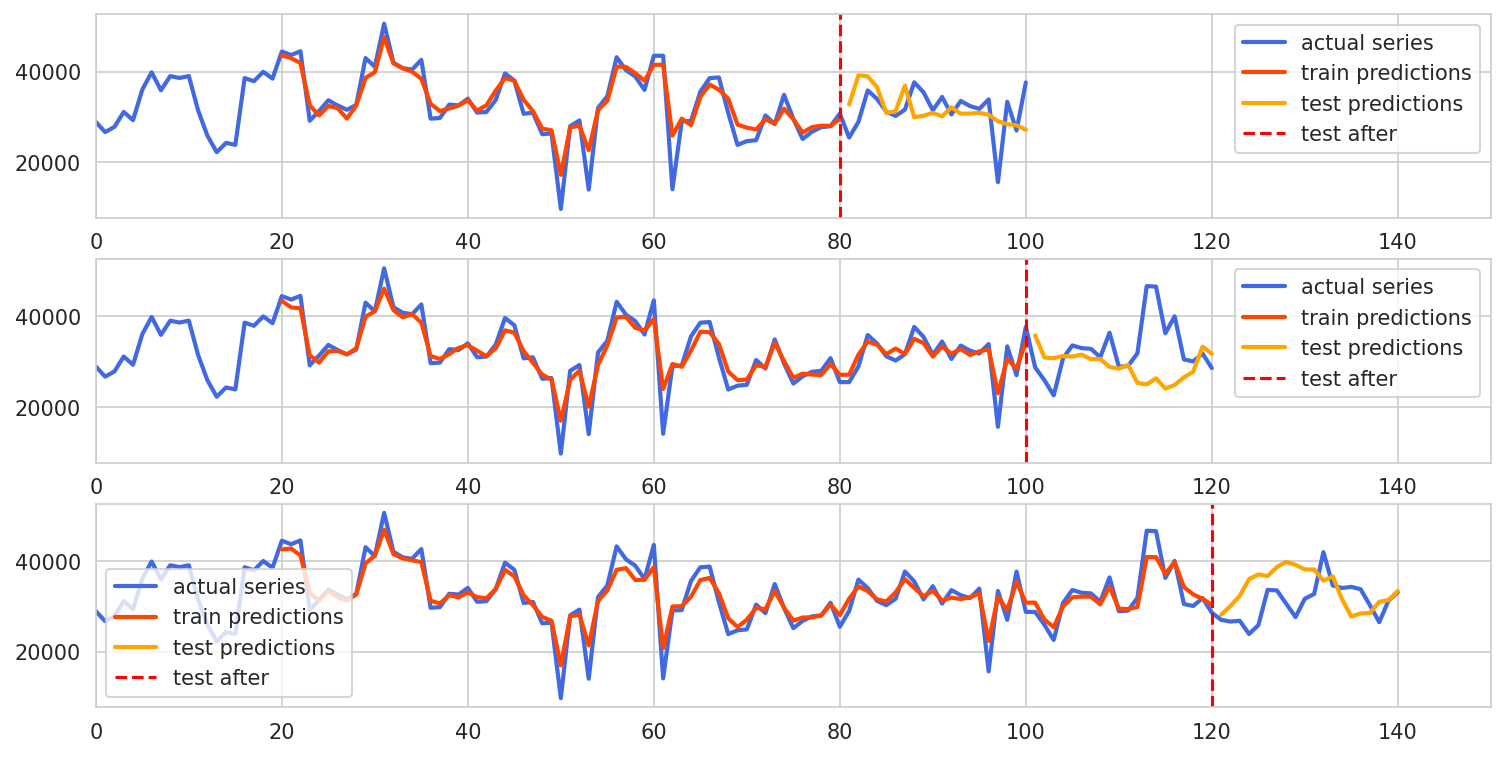

In [ ]:
fig, ax= plt.subplots(3,1, figsize=(12, 6), dpi=150)
back_tick=[80,100,120]
for t in range(3):
  X_train, y_train= backtesting_train[t]
  X_test, y_test = backtesting_test[t]
  true = np.concatenate([df.iloc[:20]['num_orders'], y_train[:,0], y_train[-1,:] , y_test.reshape(-1)])
  ax[t].plot(true,color='royalblue', linewidth=2, label='actual series')

  train_prd = 1/y_scale * np.concatenate([predictions_train[t][:,0], predictions_train[t][-1,:]])
  test_prd =  1/y_scale * predictions_test[t].reshape(-1)

  ax[t].plot(np.arange(20,20+train_prd.shape[0]),train_prd,color='orangered', linewidth=2, label='train predictions')
  ax[t].plot(np.arange(20+train_prd.shape[0],20+train_prd.shape[0]+test_prd.shape[0]),test_prd,color='orange', linewidth=2, label='test predictions')
  ax[t].axvline(x = back_tick[t], color = 'red', linestyle='--', label='test after')
  ax[t].set_xlim(0,150)
  ax[t].legend()



## **Backtest Metrics for all models**

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

model_str = ["LinearRession", "Lasso", "Ridge","KNeighbors", "SVM", "DecisionTree", 'RandomForest','GradientBoosting', 'XGBoost', 'LightGBM']
model_list = [LinearRegression,Lasso, Ridge, KNeighborsRegressor, SVR, DecisionTreeRegressor, RandomForestRegressor, GradientBoostingRegressor, XGBRegressor, lgb.LGBMRegressor]
metrics = []
for i in tqdm(range(len(model_list)), "Backtesting All Models..."):
  m = model_list[i]

  for t in range(3):
    X_train, y_train= backtesting_train[t]
    X_test, y_test = backtesting_test[t]

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train.reshape(X_train.shape[0], -1)) #flatten time, dim
    X_test = sc.transform(X_test.reshape(X_test.shape[0], -1)) #flatten time, dim
    y_scale = 1e-5
    y_train, y_test = y_train*y_scale, y_test*y_scale

    model = MultiOutputRegressor(m())
    model.fit(X_train, y_train)

    # y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    predictions_train.append(y_train_pred)
    predictions_test.append(y_test_pred)
    mse = mean_squared_error(y_test_pred.reshape(-1), y_test.reshape(-1))
    rmse = mean_squared_error(y_test_pred.reshape(-1), y_test.reshape(-1))**0.5
    mae = mean_absolute_error(y_test_pred.reshape(-1), y_test.reshape(-1))
    map = mape(y_test_pred.reshape(-1), y_test.reshape(-1))
    metrics.append([model_str[i], t, mse, rmse, mae, map]) #model name, backtest period, *metrics









Backtesting All Models...:   0%|          | 0/10 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
df_results = pd.DataFrame(metrics, columns=['Model', 'BackPeriod', 'MSE','RMSE', 'MAE', 'MAPE'])
df_results

,Model,BackPeriod,MSE,RMSE,MAE,MAPE
0,LinearRession,0,0.011618,0.107788,0.088001,28.238966
1,LinearRession,1,0.037351,0.193264,0.151738,45.110452
2,LinearRession,2,0.151870,0.389705,0.340288,109.599239
3,Lasso,0,0.002369,0.048668,0.034921,13.587348
4,Lasso,1,0.003783,0.061506,0.042361,12.445034
5,Lasso,2,0.001899,0.043580,0.034637,11.737306
6,Ridge,0,0.010904,0.104424,0.085966,27.621303
7,Ridge,1,0.029824,0.172696,0.134580,39.773633
8,Ridge,2,0.104325,0.322995,0.264944,85.335617
9,KNeighbors,0,0.003621,0.060176,0.046622,16.897515


In [ ]:
df_results_all = df_results.groupby(['Model']).mean().drop(columns=['BackPeriod']).sort_values('MAE')
df_results_all

,MSE,RMSE,MAE,MAPE
Model,,,,
Lasso,0.002684,0.051251,0.037306,12.589896
SVM,0.003486,0.057873,0.044546,13.948335
KNeighbors,0.003752,0.060025,0.046211,15.122022
RandomForest,0.004527,0.066347,0.050069,16.251799
LightGBM,0.004473,0.065330,0.053424,17.326527
GradientBoosting,0.006698,0.080723,0.061179,19.438783
XGBoost,0.008705,0.092671,0.071549,23.286155
DecisionTree,0.015420,0.123264,0.093702,29.815670
Ridge,0.048351,0.200038,0.161830,50.910184


In [ ]:
df_results_all.to_csv("ts_ml.csv")

In [ ]:
y_test_pred.shape

(1, 20)

## **DL Model**

In [ ]:
!nvidia-smi

In [ ]:
!pip install -q torchsummaryX

In [ ]:
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import gc

import zipfile
import pandas as pd
from tqdm import tqdm
import os
import datetime

from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.api import VAR
import sklearn.metrics as metrics
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import scipy.stats as stats

#import shap #explainable AI - XAI
from sklearn.ensemble import RandomForestRegressor
import pmdarima as pm #auto arima

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", DEVICE)

Device:  cpu
Device:  cpu


In [ ]:

X= np.array(df)
# y= np.array(df['num_orders'])

X_train= X[:80]
X_test= X[80:]

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X = sc.transform(X)
# y_scale = 1e-5
# y_train, y_test = y_train*y_scale, y_test*y_scale
X_train.shape

(80, 11)

In [ ]:
class TransformerDecoderDataset(Dataset):
    def __init__(self, data, indices, seq_len, pred_len) :
        super().__init__()
        self.data = data
        self.indices = indices
        self.seq_len = seq_len
        self.pred_len= pred_len

    def __len__(self):
        return len(self.indices)

    def get_sequence(self, sequence, seq_len) :
                          #65 days     60 days,      5 days
        tgt = sequence[0:-self.pred_len]     #0~7 inclusive
        true = sequence[-self.pred_len:]     #1~8 inclusive

        return tgt, true

    def __getitem__(self, index):
        start, end = self.indices[index]
        sequence = self.data[start:end]
        tgt, true = self.get_sequence(sequence, self.seq_len)

        return tgt, true


In [ ]:
def get_windows(data, window_size, step_size=1):
    # Start the first sub-sequence at index position 0
    start = 0
    end = window_size

    indices = []
    while end <= len(data)-1:      #proceed window by step size, count how many sequences
        indices.append((start, end))
        start += step_size
        end += step_size
    return indices

In [ ]:
df.columns

Index(['week_cos_month', 'week_sin_month', 'week_cos_quarter',
       'week_sin_quarter', 'week', 'meal_id', 'num_orders', 'checkout_price',
       'base_price', 'emailer_for_promotion', 'homepage_featured'],
      dtype='object')

[(0, 40), (1, 41), (2, 42), (3, 43), (4, 44), (5, 45), (6, 46), (7, 47), (8, 48), (9, 49), (10, 50), (11, 51), (12, 52), (13, 53), (14, 54), (15, 55), (16, 56), (17, 57), (18, 58), (19, 59), (20, 60), (21, 61), (22, 62), (23, 63), (24, 64), (25, 65), (26, 66), (27, 67), (28, 68), (29, 69), (30, 70), (31, 71), (32, 72), (33, 73), (34, 74), (35, 75), (36, 76), (37, 77), (38, 78), (39, 79)]
torch.Size([4, 20, 11]) torch.Size([4, 20, 11])
x:  tensor([ 1.6054, -0.5003, -0.2061,  0.1174, -0.0381, -0.1697, -0.0232,  1.3992,
         1.1344,  2.4413,  1.2604,  1.0932,  1.0486,  1.3443, -0.4376, -0.4185,
        -0.0120, -0.0359,  0.1660, -0.2562])
y_train:  tensor([-0.2358,  0.1284,  0.9333,  0.7138, -0.2905, -0.2592, -0.9089, -0.8871,
        -3.1774, -0.6690, -0.4918, -2.5882, -0.1123,  0.2414,  1.4246,  1.0334,
         0.8411,  0.4331,  1.4684, -2.5776])


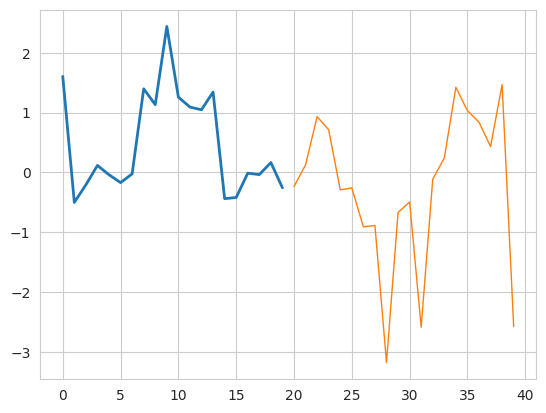

In [ ]:
# Dataset Dataloader:
#TODO: tune context_len and pred_len
context_len=20
pred_len=20
window_len=context_len+pred_len
training_indices = get_windows(X_train, window_len, step_size=1) #TODO: Tune step size...
val_indices = get_windows(X_test,window_len, step_size=1) #TODO: Tune step size...
test_indices = get_windows(X, window_len, step_size=pred_len)

print(training_indices)
train_data=TransformerDecoderDataset(torch.FloatTensor(X_train), training_indices, window_len, pred_len=pred_len)
val_data=TransformerDecoderDataset(torch.FloatTensor(X_test), val_indices, window_len, pred_len=pred_len)
test_data=TransformerDecoderDataset(torch.FloatTensor(X), test_indices, window_len, pred_len=pred_len)

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = 4,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = 1,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    batch_size  = 1,
    pin_memory  = False,
    shuffle=False
)

for batch in train_loader:
    tgt, y_train=batch
    print(y_train.shape, tgt.shape)
    print("x: ", tgt[0,:,6])
    print("y_train: ", y_train[0,:,6])  #True label should shift by one to right
    plt.plot(tgt[0,:,6], linewidth=2)
    plt.plot(np.arange(context_len, window_len),y_train[0,:,6], linewidth=1)
    break

In [ ]:
class PositionalEncoder(nn.Module):
    def __init__(self, dropout= 0.1, max_seq_len = 5000, d_model = 512):

        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_seq_len).unsqueeze(1)
        exp_input = torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model)
        div_term = torch.exp(exp_input) # Returns a new tensor with the exponential of the elements of exp_input
        pe = torch.zeros(max_seq_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term) # torch.Size([target_seq_len, dim_val])
        pe = pe.unsqueeze(0).transpose(0, 1) # torch.Size([target_seq_len, input_size, dim_val])
        # register that pe is not a model parameter
        self.register_buffer('pe', pe)

    def forward(self, x) :
        add = self.pe[:x.size(1), :].squeeze(1)
        x = x + add
        return self.dropout(x)


In [ ]:
class Transformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1,encode_seq_len=60,pred_seq_len=10):
        super(Transformer, self).__init__()
        self.nhead=nhead
        self.d_model=d_model
        self.encode_seq_len=encode_seq_len
        self.embedding = nn.Linear(input_dim, d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        # self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        self.pred_seq_len=pred_seq_len
        self.linear_out = nn.Linear(d_model*context_len, output_dim)
        self.positional_encoding_layer = PositionalEncoder(dropout, encode_seq_len, d_model )
        self.linear_scale = nn.Linear(input_dim * context_len, output_dim)

    def forward(self, x):
        # print("in,",x.shape) #32 10 29, batch len feature
        batch_size, seq_len, feature=x.shape
        # #encode x
        out = self.embedding(x)
        out = self.positional_encoding_layer(out)
        # encoder_out = self.encoder(x)
        # mask=torch.nn.Transformer.generate_square_subsequent_mask(out.shape[1]).to(device)
        decoder_out = self.encoder(out, mask=None)
        decoder_out = self.linear_out(decoder_out.flatten(1))

        return decoder_out #+ self.linear_scale(x.flatten(1))*1 #128, 7


In [ ]:
#TODO: tune model parameters
model=Transformer(input_dim=X.shape[-1], output_dim=pred_len, d_model=128, nhead=4,
                  num_encoder_layers=4, num_decoder_layers=0, dim_feedforward=52,
                  dropout=0.3, encode_seq_len=context_len, pred_seq_len=pred_len).to(device)
# print(x.size)
for tgt, y in train_loader:
    tgt=torch.FloatTensor(tgt).to(device)
    y=torch.FloatTensor(y).to(device)
    print("x shape:", tgt.shape, "y shape:", y.shape)
    out=model(tgt)
    print("out shape:", out.shape)
    summary(model,tgt)
    break
print("context len:",model.encode_seq_len,"pred_len:", model.pred_seq_len)

x shape: torch.Size([4, 20, 11]) y shape: torch.Size([4, 20, 11])
out shape: torch.Size([4, 20])
                                            Kernel Shape  Output Shape  \
Layer                                                                    
0_embedding                                    [11, 128]  [4, 20, 128]   
1_positional_encoding_layer.Dropout_dropout            -  [4, 20, 128]   
2_encoder.layers.0.Dropout_dropout1                    -  [4, 20, 128]   
3_encoder.layers.0.LayerNorm_norm1                 [128]  [4, 20, 128]   
4_encoder.layers.0.Linear_linear1              [128, 52]   [4, 20, 52]   
5_encoder.layers.0.Dropout_dropout                     -   [4, 20, 52]   
6_encoder.layers.0.Linear_linear2              [52, 128]  [4, 20, 128]   
7_encoder.layers.0.Dropout_dropout2                    -  [4, 20, 128]   
8_encoder.layers.0.LayerNorm_norm2                 [128]  [4, 20, 128]   
9_encoder.layers.1.Dropout_dropout1                    -  [4, 20, 128]   
10_encoder.laye

In [ ]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= 1e-4, weight_decay = 0.001)
criterion   = torch.nn.MSELoss()
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
# Optional (but Recommended): Create a custom class for a Teacher Force Schedule

In [ ]:
class Trainer():
  def __init__(self):
    self.train_plot=[]


  def train(self):
      model.train() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(train_loader):
          optimizer.zero_grad()

          tgt, y_train = batch

          tgt = tgt.to(device)
          y_train = y_train.to(device)
          y_pred = model(tgt).squeeze()

          #0,'Time',1,'Open',2,'High',3,'Low',4,'Close',5,'Volume',6,'change',7,'delta',8,'Moving Average'
          pred_what=6
          # print(y_pred.shape, y_train[:,:,pred_what].shape)
          loss = criterion(y_pred, y_train[:,:,pred_what])    #TODO: try changing 8 to others, if want the model to learn other columns
          loss.backward()
          optimizer.step()

          self.train_plot.append(loss.item())
          running_loss += loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1)),
              lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
              # teacher_time="{:.04f}".format(teach/10)
               )
          batch_bar.update()

          del tgt, y_train
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(train_loader)

  def validate(self):
      model.eval() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(val_loader):
          optimizer.zero_grad()
          trg, y_test = batch

          trg = trg.to(device)
          y_test = y_test.to(device)

          y_pred = model(trg).squeeze()
          #0,'Time',1,'Open',2,'High',3,'Low',4,'Close',5,'Volume',6,'change',7,'delta',8,'Moving Average'
          pred_what=6
          val_loss = criterion(y_pred, y_test[:,:,pred_what])    #TODO: try changing 8 to others, if want the model to learn other columns

          running_loss += val_loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1))
               )
          batch_bar.update()

          del trg, y_test
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(val_loader)

  def test(self):
        model.eval() # set to training mode
        model.to(device)
        batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
        prediction=[]
        for i, batch in enumerate(test_loader):
            optimizer.zero_grad()
            trg, y_test = batch

            trg = trg.to(device)
            # y_test = y_test.to(device)

            y_pred = model(trg)
            prediction.append(y_pred)

            #0,'Time',1,'Open',2,'High',3,'Low',4,'Close',5,'Volume',6,'change',7,'delta',8,'Moving Average'
            del trg, y_test
            torch.cuda.empty_cache()
            batch_bar.update()

        batch_bar.close()

        return prediction


Epoch: 1/5


	Train Loss 1.4045	 Learning Rate 0.0001000	 Validation Loss 0.7630

Epoch: 2/5


	Train Loss 1.2545	 Learning Rate 0.0000950	 Validation Loss 0.7473

Epoch: 3/5


	Train Loss 1.1888	 Learning Rate 0.0000902	 Validation Loss 0.6985

Epoch: 4/5


	Train Loss 1.0880	 Learning Rate 0.0000857	 Validation Loss 0.7196

Epoch: 5/5


	Train Loss 1.0292	 Learning Rate 0.0000815	 Validation Loss 0.7074


Text(0.5, 1.0, 'Validation loss')

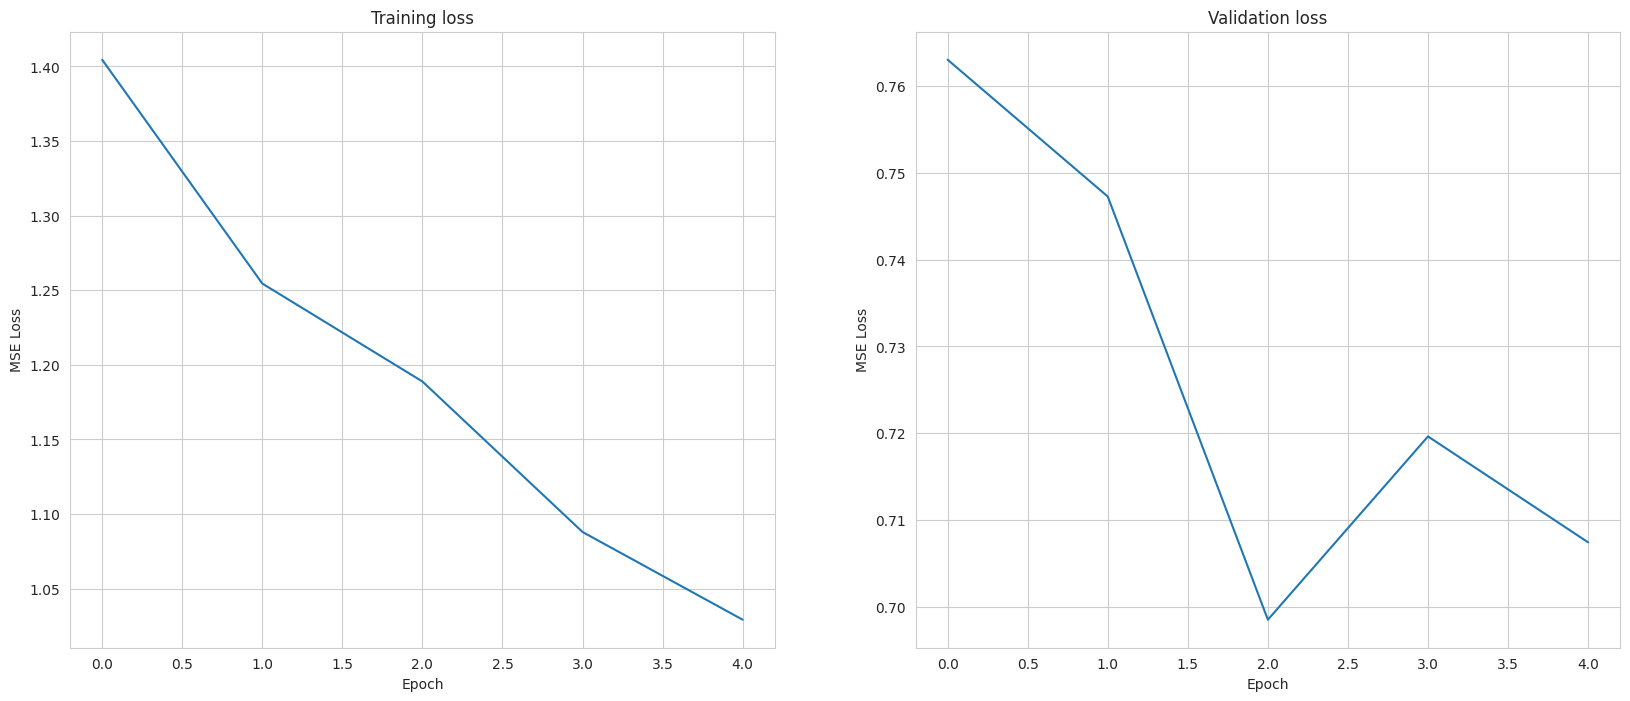

In [ ]:
trainer=Trainer()
optimizer.param_groups[0]['lr']=1e-4
epoch_plot=[]
val_plot=[]
num_epochs=5
for epoch in range(0, num_epochs):

    # Call train and validate
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_loss              = trainer.train()
    epoch_plot.append(train_loss)

    val_loss              = trainer.validate()
    val_plot.append(val_loss)

    # trainer.teacher_forcing_ratio=max(trainer.teacher_forcing_ratio-0.05,0.1)
    scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}\t Validation Loss {:.04f}".format(train_loss, curr_lr, val_loss))

fig, ax=plt.subplots(1,2, figsize=(20,8))
# ax[0].plot(trainer.train_plot)
ax[0].plot(epoch_plot)
ax[0].set_ylabel("MSE Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Training loss")

ax[1].plot(val_plot)
ax[1].set_ylabel("MSE Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Validation loss")


In [ ]:
prediction=trainer.test()
prediction=[i.cpu().detach().numpy() for i in prediction]
prediction = np.concatenate(prediction).reshape(-1)
prediction.shape

(120,)

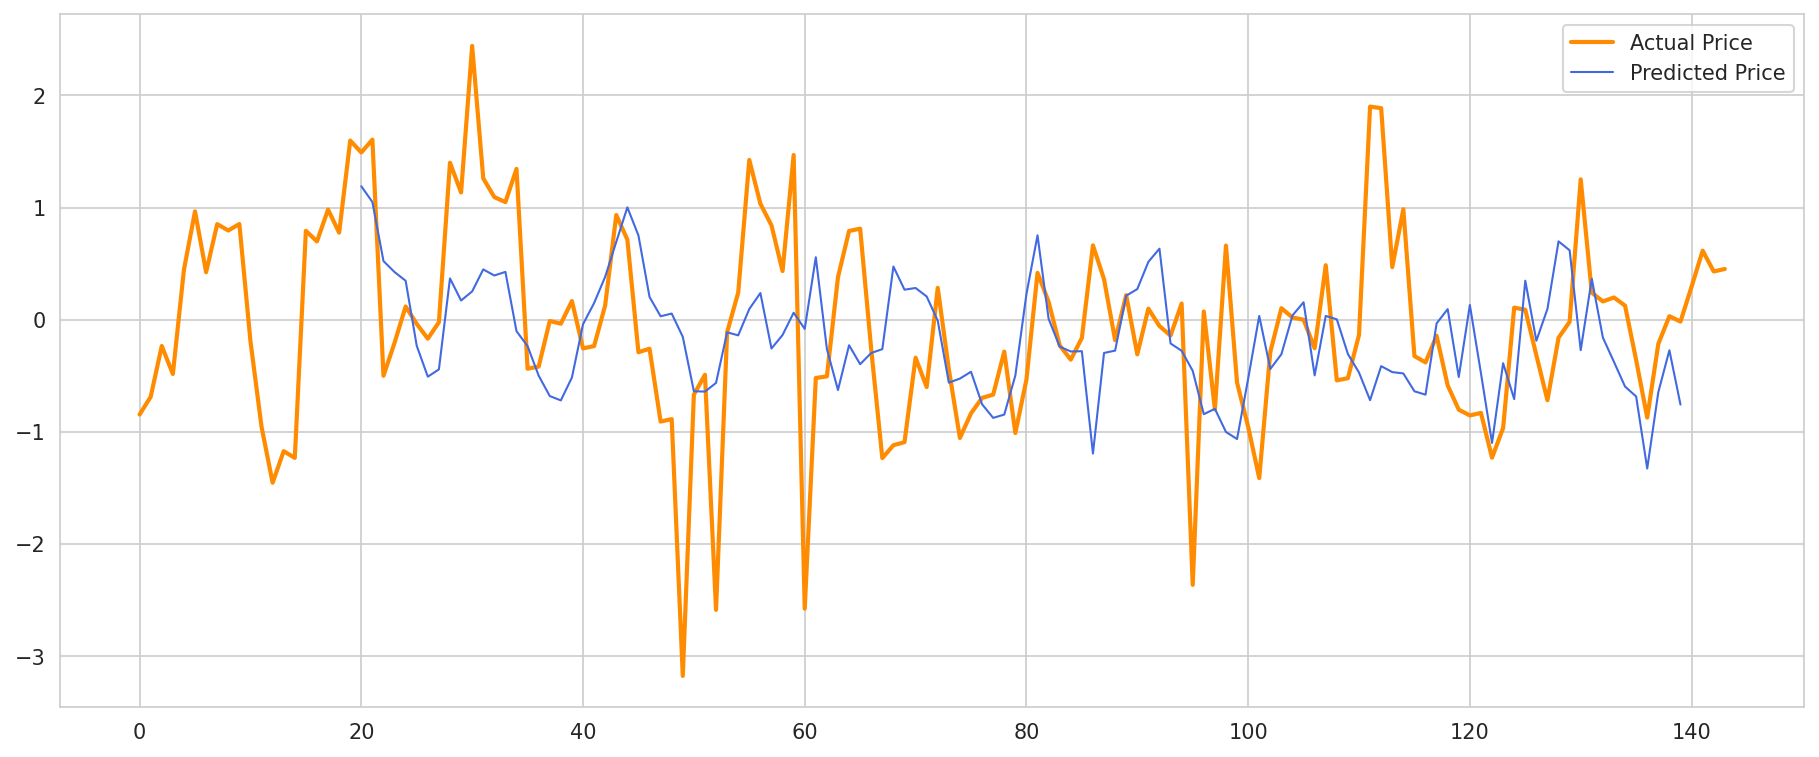

In [ ]:
plt.figure(figsize=(15,6), dpi=150)
plt.plot(np.array(X)[1:,6], label='Actual Price', color='darkorange', linewidth=2)
plt.plot(np.arange(20,prediction.shape[0]+20), prediction, label='Predicted Price',color='royalblue', linewidth=1)
plt.legend()


In [ ]:

class LSTM_Block(nn.Module):
  def __init__(self, input_dim, output_dim, dropout=0.3):
    super(LSTM_Block, self).__init__()
    self.lstm = nn.LSTM(input_dim, output_dim, num_layers=1, bias=True, batch_first=False)
    self.bn= nn.BatchNorm1d(output_dim)
    self.dp = nn.Dropout(dropout)
    self.act = nn.GELU()
  def forward(self, x):
    out,_ = self.lstm(x)
    out = self.bn(out.permute(0,2,1)).permute(0,2,1)
    out = self.dp(out)
    # out = self.act(out)
    return out

class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=512, dropout=0.3):
        super(LSTM, self).__init__()
        self.d_model=d_model
        self.model = torch.nn.Sequential(
            LSTM_Block(input_dim, d_model),
            LSTM_Block(d_model, d_model),
            nn.Linear(d_model,d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model,output_dim)
        )
        self.linear_scale = nn.Linear(context_len,pred_len)
        self.linear_out = nn.Linear(context_len*output_dim, pred_len*output_dim)

    def forward(self, x):
        return self.linear_out(self.model(x).flatten(1)) + self.linear_scale(x[:,:,6].flatten(-1))*0.2


In [ ]:
#TODO: tune model parameters
model=LSTM(input_dim=X.shape[-1], output_dim=1, d_model=256, dropout=0.6).to(device)
# print(x.size)
for tgt, y in train_loader:
    tgt=torch.FloatTensor(tgt).to(device)
    y=torch.FloatTensor(y).to(device)
    print("x shape:", tgt.shape, "y shape:", y.shape)
    out=model(tgt)
    print("out shape:", out.shape)
    summary(model,tgt)
    break

x shape: torch.Size([4, 20, 11]) y shape: torch.Size([4, 2, 11])
out shape: torch.Size([4, 2])
                         Kernel Shape  Output Shape    Params Mult-Adds
Layer                                                                  
0_model.0.LSTM_lstm                 -  [4, 20, 256]  275.456k  273.408k
1_model.0.BatchNorm1d_bn        [256]  [4, 256, 20]     512.0     256.0
2_model.0.Dropout_dp                -  [4, 20, 256]         -         -
3_model.1.LSTM_lstm                 -  [4, 20, 256]  526.336k  524.288k
4_model.1.BatchNorm1d_bn        [256]  [4, 256, 20]     512.0     256.0
5_model.1.Dropout_dp                -  [4, 20, 256]         -         -
6_model.Linear_2           [256, 256]  [4, 20, 256]   65.792k   65.536k
7_model.GELU_3                      -  [4, 20, 256]         -         -
8_model.Dropout_4                   -  [4, 20, 256]         -         -
9_model.Linear_5             [256, 1]    [4, 20, 1]     257.0     256.0
10_linear_out                 [20, 2]    

In [ ]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= 1e-4, weight_decay = 0.001)
criterion   = torch.nn.MSELoss()
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
# Optional (but Recommended): Create a custom class for a Teacher Force Schedule


Epoch: 1/30


	Train Loss 1.0288	 Learning Rate 0.0001000	 Validation Loss 0.4941

Epoch: 2/30


	Train Loss 1.0404	 Learning Rate 0.0000950	 Validation Loss 0.4933

Epoch: 3/30


	Train Loss 1.0831	 Learning Rate 0.0000902	 Validation Loss 0.4993

Epoch: 4/30


	Train Loss 1.0093	 Learning Rate 0.0000857	 Validation Loss 0.5180

Epoch: 5/30


	Train Loss 1.0121	 Learning Rate 0.0000815	 Validation Loss 0.5349

Epoch: 6/30


	Train Loss 0.8902	 Learning Rate 0.0000774	 Validation Loss 0.5435

Epoch: 7/30


	Train Loss 1.0015	 Learning Rate 0.0000735	 Validation Loss 0.5569

Epoch: 8/30


	Train Loss 0.9260	 Learning Rate 0.0000698	 Validation Loss 0.5641

Epoch: 9/30


	Train Loss 0.8984	 Learning Rate 0.0000663	 Validation Loss 0.5843

Epoch: 10/30


	Train Loss 0.8979	 Learning Rate 0.0000630	 Validation Loss 0.5925

Epoch: 11/30


	Train Loss 1.0660	 Learning Rate 0.0000599	 Validation Loss 0.6001

Epoch: 12/30


	Train Loss 0.9810	 Learning Rate 0.0000569	 Validation Loss 0.6128

Epoch: 13/30


	Train Loss 0.8915	 Learning Rate 0.0000540	 Validation Loss 0.6324

Epoch: 14/30


	Train Loss 0.8324	 Learning Rate 0.0000513	 Validation Loss 0.6564

Epoch: 15/30


	Train Loss 0.9010	 Learning Rate 0.0000488	 Validation Loss 0.6612

Epoch: 16/30


	Train Loss 0.8534	 Learning Rate 0.0000463	 Validation Loss 0.6798

Epoch: 17/30


	Train Loss 0.8923	 Learning Rate 0.0000440	 Validation Loss 0.6751

Epoch: 18/30


	Train Loss 0.9099	 Learning Rate 0.0000418	 Validation Loss 0.6876

Epoch: 19/30


	Train Loss 0.9604	 Learning Rate 0.0000397	 Validation Loss 0.6895

Epoch: 20/30


	Train Loss 0.8378	 Learning Rate 0.0000377	 Validation Loss 0.7118

Epoch: 21/30


	Train Loss 0.9191	 Learning Rate 0.0000358	 Validation Loss 0.7045

Epoch: 22/30


	Train Loss 0.8657	 Learning Rate 0.0000341	 Validation Loss 0.7163

Epoch: 23/30


	Train Loss 0.9519	 Learning Rate 0.0000324	 Validation Loss 0.7200

Epoch: 24/30


	Train Loss 0.8342	 Learning Rate 0.0000307	 Validation Loss 0.7421

Epoch: 25/30


	Train Loss 0.9950	 Learning Rate 0.0000292	 Validation Loss 0.7346

Epoch: 26/30


	Train Loss 0.8701	 Learning Rate 0.0000277	 Validation Loss 0.7337

Epoch: 27/30


	Train Loss 0.9147	 Learning Rate 0.0000264	 Validation Loss 0.7216

Epoch: 28/30


	Train Loss 0.8047	 Learning Rate 0.0000250	 Validation Loss 0.7279

Epoch: 29/30


	Train Loss 0.8128	 Learning Rate 0.0000238	 Validation Loss 0.7446

Epoch: 30/30


	Train Loss 0.9155	 Learning Rate 0.0000226	 Validation Loss 0.7395


Text(0.5, 1.0, 'Validation loss')

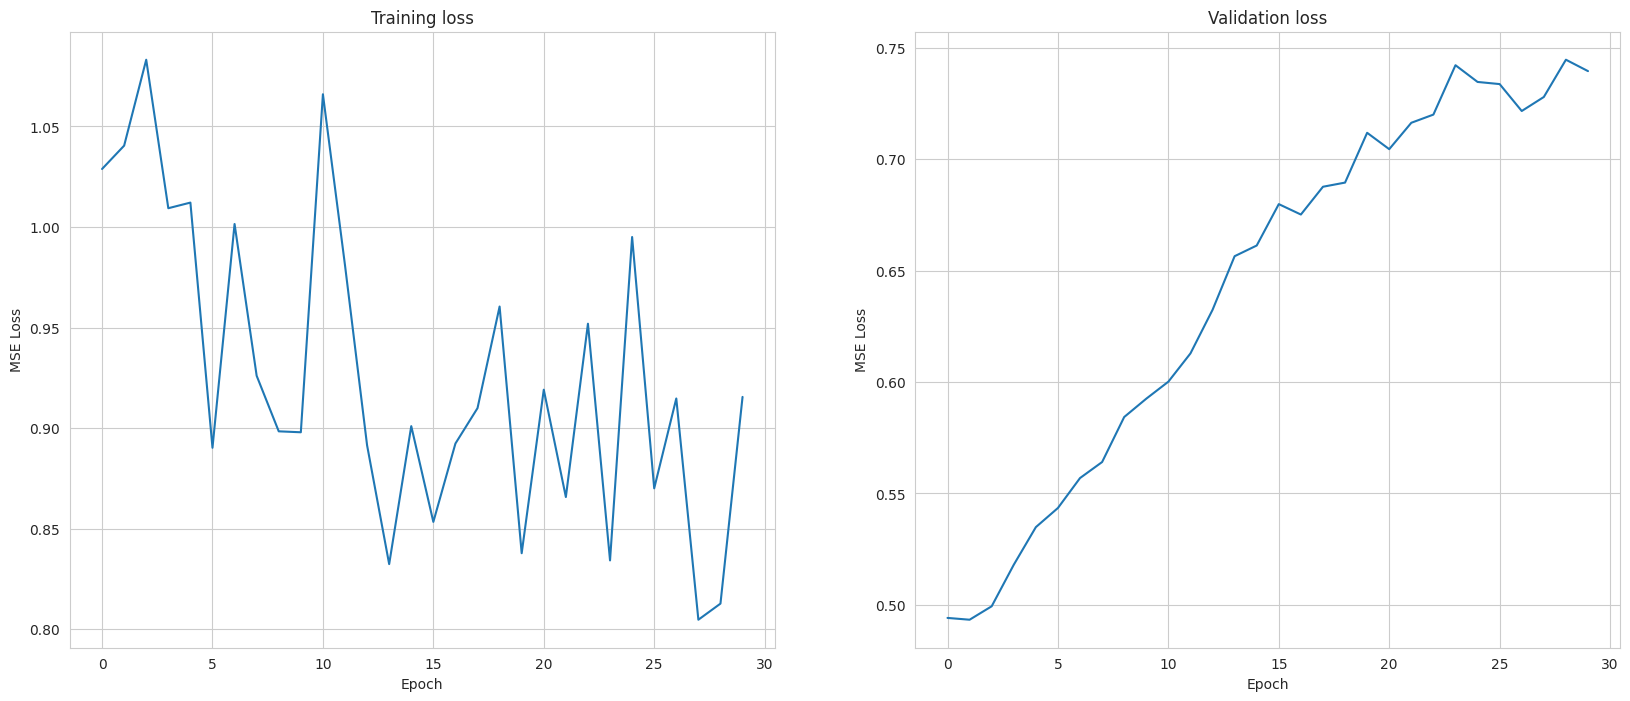

In [ ]:
trainer=Trainer()
optimizer.param_groups[0]['lr']=1e-4
epoch_plot=[]
val_plot=[]
num_epochs=30
for epoch in range(0, num_epochs):

    # Call train and validate
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_loss              = trainer.train()
    epoch_plot.append(train_loss)

    val_loss              = trainer.validate()
    val_plot.append(val_loss)

    # trainer.teacher_forcing_ratio=max(trainer.teacher_forcing_ratio-0.05,0.1)
    scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}\t Validation Loss {:.04f}".format(train_loss, curr_lr, val_loss))

fig, ax=plt.subplots(1,2, figsize=(20,8))
# ax[0].plot(trainer.train_plot)
ax[0].plot(epoch_plot)
ax[0].set_ylabel("MSE Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Training loss")

ax[1].plot(val_plot)
ax[1].set_ylabel("MSE Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Validation loss")


In [ ]:
prediction=trainer.test()
prediction=[i.cpu().detach().numpy() for i in prediction]
prediction = np.concatenate(prediction).reshape(-1)
prediction.shape

(124,)

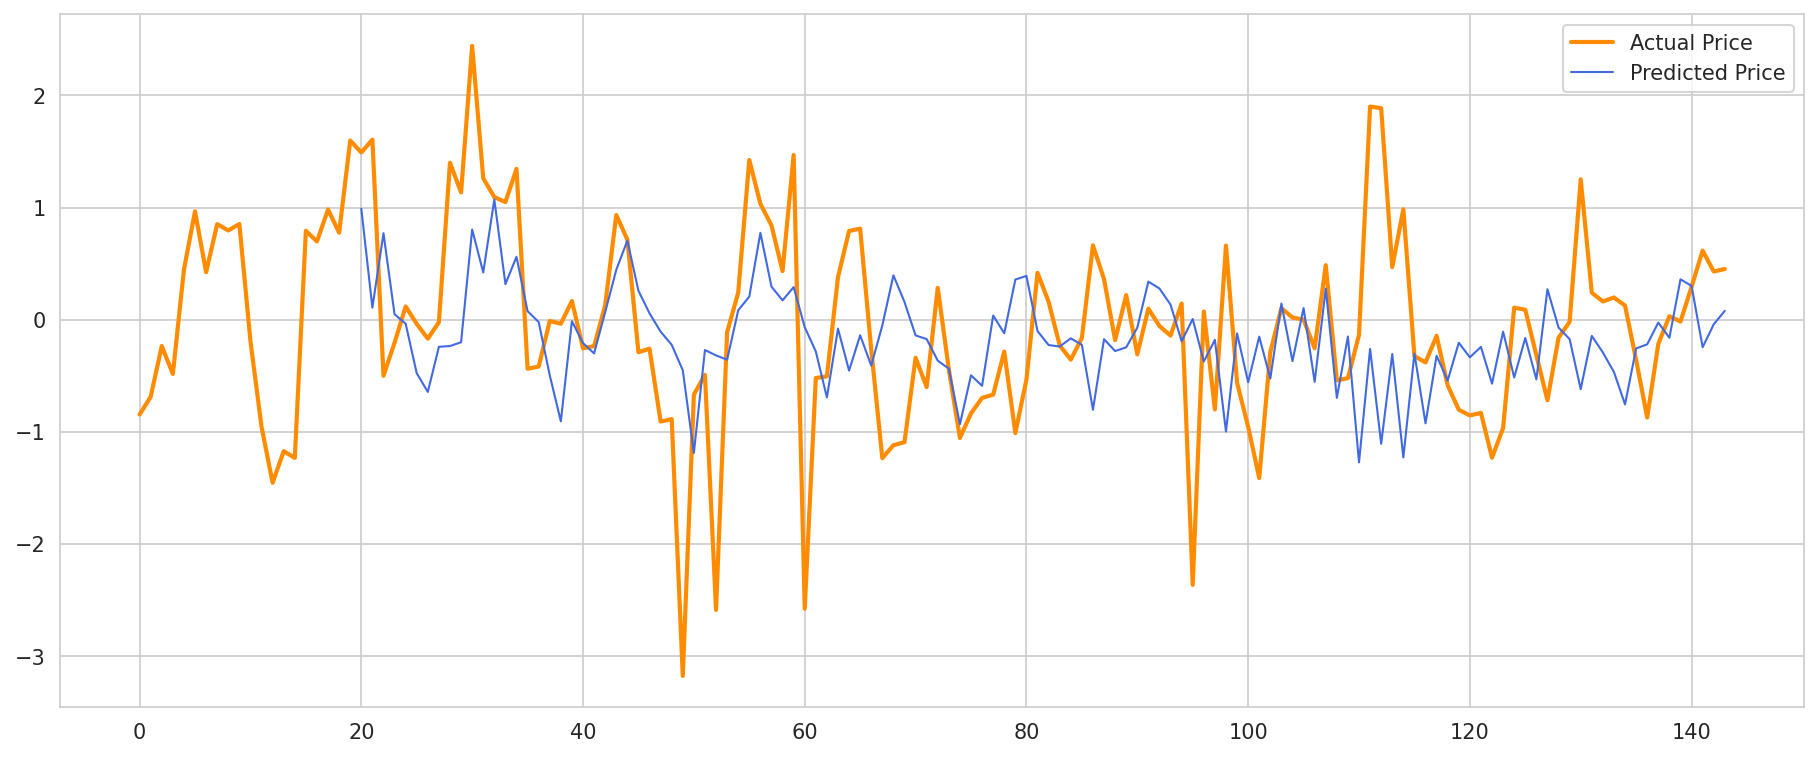

In [ ]:
plt.figure(figsize=(15,6), dpi=150)
plt.plot(np.array(X)[1:,6], label='Actual Price', color='darkorange', linewidth=2)
plt.plot(np.arange(20,prediction.shape[0]+20), prediction, label='Predicted Price',color='royalblue', linewidth=1)
plt.legend()
